In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline,DDIMScheduler
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms  
from tqdm.auto import tqdm
import pytorch_lightning as pl
from huggingface_hub import login

In [11]:
login()

In [12]:
torch.set_float32_matmul_precision('high')

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda')

In [15]:
# 载入一个预训练管线
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
pipeline = DDPMPipeline.from_pretrained(pipeline_name).to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
# 使用DDIM调度器，仅用40步生成一些图片
scheduler = DDIMScheduler.from_pretrained(pipeline_name)

In [17]:
# 导入open_clip
import open_clip

In [18]:
clip_model,_,preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32",
    pretrained="openai"
)
clip_model.to(device)

CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-

In [19]:
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomAffine(5),
        torchvision.transforms.RandomHorizontalFlip(),

        torchvision.transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711],
        )
    ]
)

In [20]:
# 定义一个clip-guided的损失函数
def clip_loss(image,text_features):
    image_features = clip_model.encode_image(tfms(image))
    input_normed = torch.nn.functional.normalize(
        image_features.unsqueeze(1),dim=2
    )
    embed_normed = torch.nn.functional.normalize(
        text_features.unsqueeze(0),dim=2
    )
    dists = (
        input_normed.sub(
            embed_normed
        ).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )
    return dists.mean()

In [21]:
prompt = "Red Rose (still life),red flower painting"
guidance_scale = 8
n_cuts = 4

In [22]:
# 设置时间步
scheduler.set_timesteps(50)

In [23]:
# 使用CLIP从提示文字中获取特征
text = open_clip.tokenize([prompt]).to(device)

In [24]:
with torch.no_grad(),torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)

In [25]:
x = torch.randn(4,3,256,256).to(device)

In [26]:
losses = []

0it [00:00, ?it/s]

/root/anaconda3/envs/hugging/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


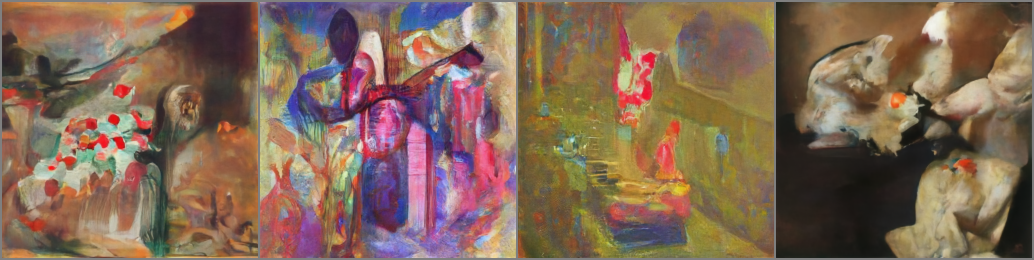

In [27]:
for i,t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x,t)
    # 预测噪声
    with torch.no_grad():
        noise_pred = pipeline.unet(
            model_input,t
        )['sample']
    cond_grad = 0

    for cut in range(n_cuts):
        x = x.detach().requires_grad_()
        x0 = scheduler.step(
            noise_pred,t,x
        ).pred_original_sample
        loss = clip_loss(
            x0,text_features
        ) * guidance_scale
        cond_grad -= torch.autograd.grad(
            loss,x
        )[0] / n_cuts

    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )
    x = scheduler.step(
        noise_pred,t,x
    ).prev_sample
    losses.append(loss.item())
    print(f"Epoch {i} loss: {loss.item():.2f}")
grid = torchvision.utils.make_grid(
    x.detach(),nrow=4)
im = grid.permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255,dtype=np.uint8))

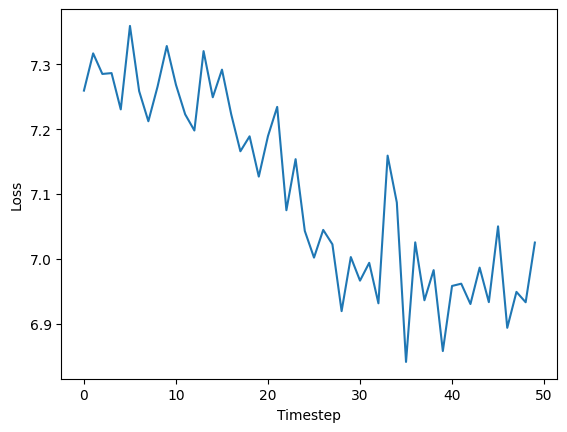

In [28]:
plt.plot(losses)
plt.xlabel("Timestep")
plt.ylabel("Loss")
plt.show()

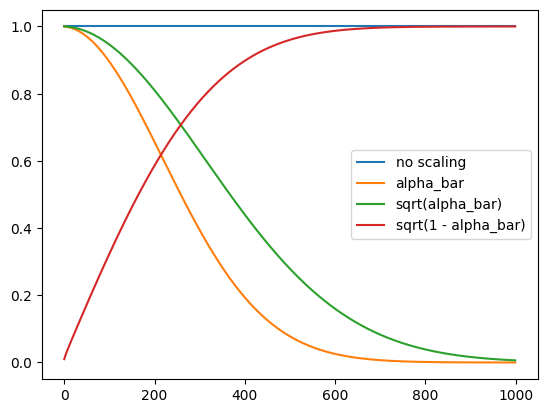

In [29]:
plt.plot([1 for a in scheduler.alphas_cumprod],label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod],label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod],label="sqrt(alpha_bar)")
plt.plot([(1 - a).sqrt() for a in scheduler.alphas_cumprod],label="sqrt(1 - alpha_bar)")
plt.legend()

In [30]:
# 保存模型
pipeline.save_pretrained("my-clip-guided-pipeline")